# Introduction to Machine Learning
## Lecture 4 - Logistic Discrimination
### Notebook 3: Logistic Regression on Credit Card Fraud Detection
Prapared by: Said Bolluk

Try to understand the dataset: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Data Preparation

In [2]:
data = pd.read_csv("../datasets/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Create a copy of the dataset for the future use
fraud_data = data.copy()

In [4]:
data.shape

(284807, 31)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Let us check the class distribution of the target variable: **Class**. Ones (C=1) tell us the transaction is a fraud where zeros (C==0) indicates that the transaction is normal.

In [6]:
data["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

We see that the dataset is highly imbalanced. Therefore, we will remove some of the zeros and make the class distribution even.

In [7]:
ratio = 1 - (data["Class"].value_counts()[1] / data["Class"].value_counts()[0])
ratio

0.998269524998681

We will remove around 99% of the instances with zero labels to balance the class distribution.

In [8]:
data = data.drop(data.loc[data["Class"]==0].sample(frac=0.995).index)

In [9]:
data["Class"].value_counts()

0    1422
1     492
Name: Class, dtype: int64

In [10]:
data.shape

(1914, 31)

In [11]:
target_name = "Class"
target = data[target_name]

data = data.drop(columns=[target_name])

## Feature Selection

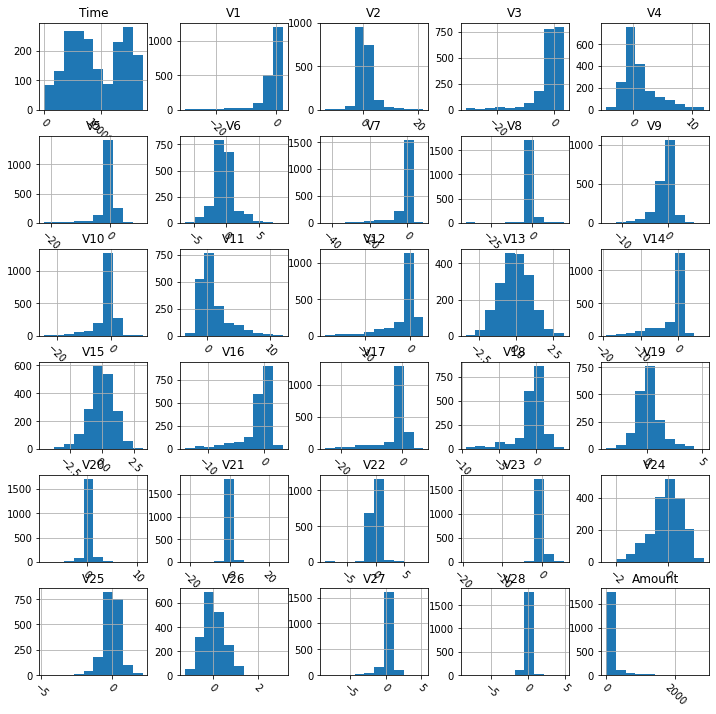

In [12]:
# Histogram view for the numerical features
data.hist(bins=10, figsize=(12, 12), xrot=-45)
plt.show()

We can see from the above graph that most of the features have outliners and are not Gaussian. Therefore, we will select a subset of the features that are promising and continue the analysis.

In [13]:
features = [
    "Time", "Amount", "V3", "V4", "V6", "V9", 
    "V10", "V11", "V13", "V15", "V16", "V17", 
    "V18", "V19", "V24", "V25", "V26",
]

data = data[features]
data.shape

(1914, 17)

## Preprocessing

This time we will use a **validation curve** to determine the optimal hyperparameter of the classifier. Therefore, we will split the data into three sets: Training, Validation, and Test. Training and validation sets will be used for hyperparameter tuning, while the final results will be derived over the test set.

In [14]:
# First, split data into training and test sets

X = data.values
y = target.values

# Split the data into training and test sets
from sklearn.model_selection import train_test_split

X_pre, X_test, y_pre, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_pre, y_pre, test_size=0.30, stratify=y_pre,random_state=42)

print("Training size:", X_train.shape[0])
print("Validation size:", X_val.shape[0])
print("Test size:", X_test.shape[0])

print("Class distribution for training set:", np.bincount(y_train))
print("Class distribution for validation set:", np.bincount(y_val))
print("Class distribution for test set:", np.bincount(y_test))

Training size: 1071
Validation size: 460
Test size: 383
Class distribution for training set: [795 276]
Class distribution for validation set: [342 118]
Class distribution for test set: [285  98]


In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()  
scaler.fit(X_train)  
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression

We will use an existing library for Logistic Regression: **SGD Classifier**. It is an incrementally trained logistic regression with the log-loss function. The hyperparameter that we will tune is the regularization constant that determines the regularization strength. The higher this value, the stronger the regularization is. We will define its optimal parameter using the training and validation set. Then we will train the model using this setting and make predictions over the test set.

In [16]:
from sklearn.linear_model import SGDClassifier

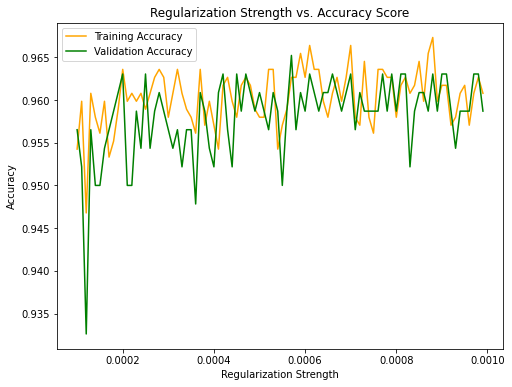

In [17]:
regu_list = np.arange(10, 100) * 1e-5

training_acc = list()
validation_acc = list()

for constant in regu_list:
    
    # Define a model
    logi = SGDClassifier(
        alpha=constant,
        max_iter=100,
        random_state=42,
    )
    
    # Train the model
    logi.fit(X_train_scaled, y_train)
    
    # Make predictions
    train_pred = logi.predict(X_train_scaled)
    val_pred = logi.predict(X_val_scaled)

    # Calculate the accuracy
    acc_train = np.sum(y_train==train_pred) / y_train.shape[0]
    acc_val = np.sum(y_val==val_pred) / y_val.shape[0]
    
    training_acc.append(acc_train)
    validation_acc.append(acc_val)
    
# Visualize the results
plt.figure(figsize=(8, 6))
plt.plot(regu_list, training_acc, color="orange", label="Training Accuracy")
plt.plot(regu_list, validation_acc, color="green", label="Validation Accuracy")
plt.title("Regularization Strength vs. Accuracy Score")
plt.legend()
plt.xlabel("Regularization Strength")
plt.ylabel("Accuracy")
plt.show()

Note that as we increase the regularization strength, the accuracy of the validation set increases. This is because we tell the model to generalize the dataset rather than only minimizing the training error. However, after peaking at around 2e-4, the validation accuracy is not constantly improved. Therefore, we will set alpha=2e-4.

In [18]:
# Define a model
logi = SGDClassifier(
    alpha=2e-4, 
    max_iter=100, 
    random_state=42,
)

logi.fit(X_train_scaled, y_train)

# Make predictions
test_pred = logi.predict(X_test_scaled)

# Calculate the accuracy
acc_test = np.sum(y_test==test_pred) / y_test.shape[0]

print(f"Test Accuracy: {acc_test:.3f}")

Test Accuracy: 0.956


Let us now analyze the classification results

In [19]:
# Import the necessary libraries to analyze classification results
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [20]:
# Observe the classificaiton results
print(classification_report(y_test, logi.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       285
           1       1.00      0.83      0.91        98

    accuracy                           0.96       383
   macro avg       0.97      0.91      0.94       383
weighted avg       0.96      0.96      0.95       383



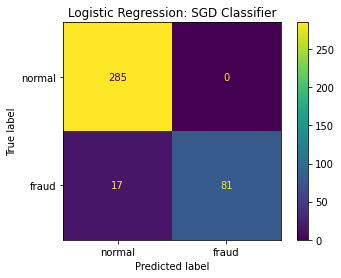

In [21]:
# Confusion Matrix
transaction = ["normal", "fraud"]
cm = confusion_matrix(y_test, logi.predict(X_test_scaled), labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=transaction)
disp.plot()
plt.title("Logistic Regression: SGD Classifier")
plt.show()

**Discussion:** As expected, the classifier prioritised the majority class (zeros) while training. We can see that the classifier made 0 misclassifications for the majority class (normal transaction) while it made 17 misclassifications for the minority class (fraud). However, the overall accuracy and the other evaluation metrics suggests that we succesfully detected the credit card transactions (whether they are fraud or normal) over a sample dataset.

# END